In [1]:
%matplotlib inline

import os
import zipfile
import logging
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from skimage import io, transform, img_as_float
from torch.utils.data import Dataset, DataLoader

os.chdir('..') # change working directory to 1 level up

LOCAL=True # SET THIS
GPU=False # SET THIS
sns.set(style="white")

## Understanding the dataset

In [2]:
train_labels = pd.read_csv("data/train.csv") if LOCAL else pd.read_csv("input/train.csv")
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [3]:
train_labels.shape

(31072, 2)

We have 31k training images to work with. This will later be split into a training and test set. Anticipating that this is a multi-classification/multi-label problem, let's split the Target variable, which are strings, into an array of one-hot-encoded variables.

In [4]:
one_hot = train_labels.Target.str.get_dummies(sep=' ')

In [5]:
one_hot.columns = map(int, one_hot.columns); one_hot.head()

,0,1,10,11,12,13,14,15,16,17,...,25,26,27,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Label names

In [6]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

## Class Counts

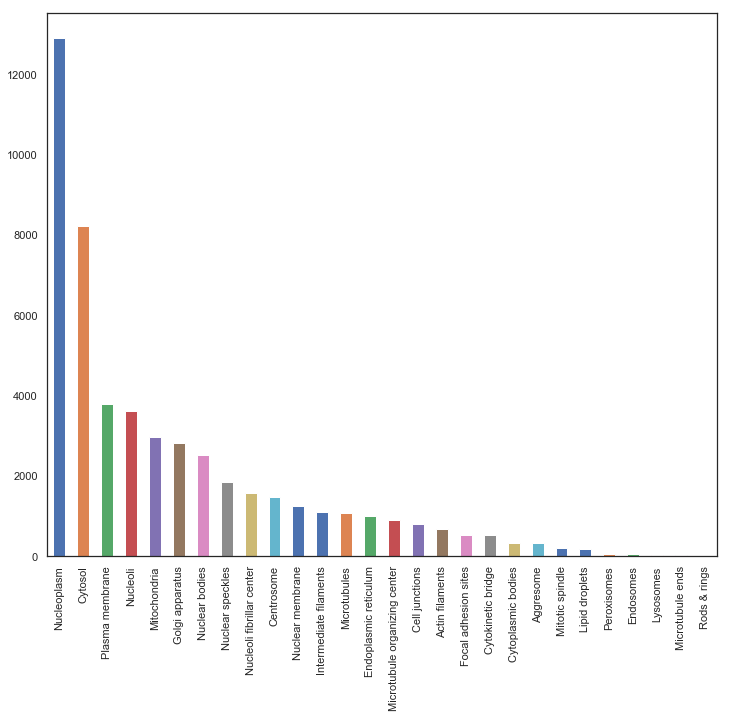

In [7]:
counts = one_hot.agg('sum')[:].rename(lambda x: label_names[x]).sort_values(ascending=False)
plt.figure(figsize=(12,10))
counts.plot('bar')

In [8]:
counts.head()

Nucleoplasm        12885
Cytosol             8228
Plasma membrane     3777
Nucleoli            3621
Mitochondria        2965
dtype: int64

In [9]:
counts.tail()

Peroxisomes         53
Endosomes           45
Lysosomes           28
Microtubule ends    21
Rods & rings        11
dtype: int64

Append one_hot labels to our train labels dataframe:

In [10]:
train_labels = train_labels.join(one_hot.sort_index(axis=1))

## Co-occurences

In [11]:
tmp1 = train_labels.iloc[:,2:]

In [12]:
co_occur = tmp1.T.dot(tmp1); co_occur.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,12885,600,1735,571,97,806,89,1092,5,0,...,279,614,58,1343,325,802,78,3631,115,7
1,600,1254,147,19,52,39,21,56,0,0,...,11,19,0,76,7,45,1,261,0,0
2,1735,147,3621,4,48,59,79,189,11,0,...,18,56,6,216,52,226,12,782,11,1
3,571,19,4,1561,23,14,24,40,4,0,...,5,20,0,35,16,51,3,272,12,0
4,97,52,48,23,1858,5,2,42,0,0,...,16,16,2,135,24,44,8,329,17,1


Now that we have a co-occurence matrix, let's plot it with a heatmap.

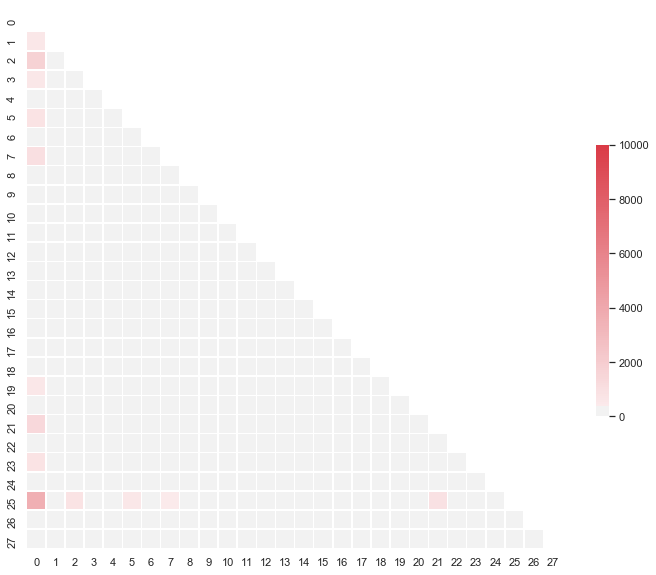

In [13]:
mask = np.zeros_like(co_occur, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(12,10))
sns.heatmap(co_occur, mask=mask, cmap=cmap, vmax=10000, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The above plot doesn't tell me much because most of the variables have so few occurences that few, can be seen above the 1k number of co-occurences. Let's try plotting it on a log base-10 scale.

In [14]:
co_occur1 = co_occur.apply(np.log, args=10)

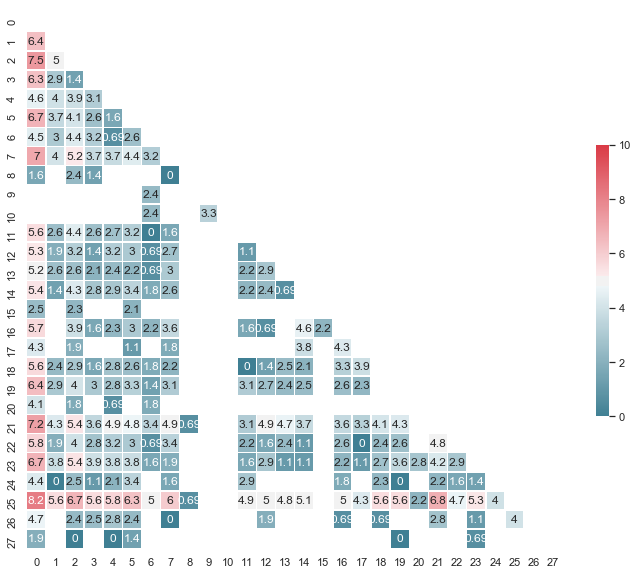

In [15]:
mask = np.zeros_like(co_occur1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12,10))
sns.heatmap(co_occur1, mask=mask, cmap=cmap, vmax=10, vmin=0, center=5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

This plot is helpful because, while still showing the high frequency of co-occurence protein 0  and 25 have with many other columns, It also shows the lack of co-occurence that protein 8,9 and 10 have with any other proteins. We may be able to use this later.

## Image reconnaissance

Let's take a look at some of the images and try to imagine what we want our net to find here

In [16]:
DIR = 'data/train_images' if LOCAL else 'input/train'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

124288


In [17]:
len(train_labels) * 4

124288

Good! The number of files in the train_images directory matches 4x the number of rows in our train_labels dataframe. There is one stained image - red, blue, green, yellow for each image Id. The below code chooses a uniform random sample of 4 images and displays each color.

In [18]:
id_list = train_labels.sample(4).Id.tolist(); id_list

['1f2511de-bba8-11e8-b2ba-ac1f6b6435d0',
 '96a2e2ee-bbbd-11e8-b2ba-ac1f6b6435d0',
 '6b1bfe68-bbc6-11e8-b2bc-ac1f6b6435d0',
 '23693f42-bbb0-11e8-b2ba-ac1f6b6435d0']

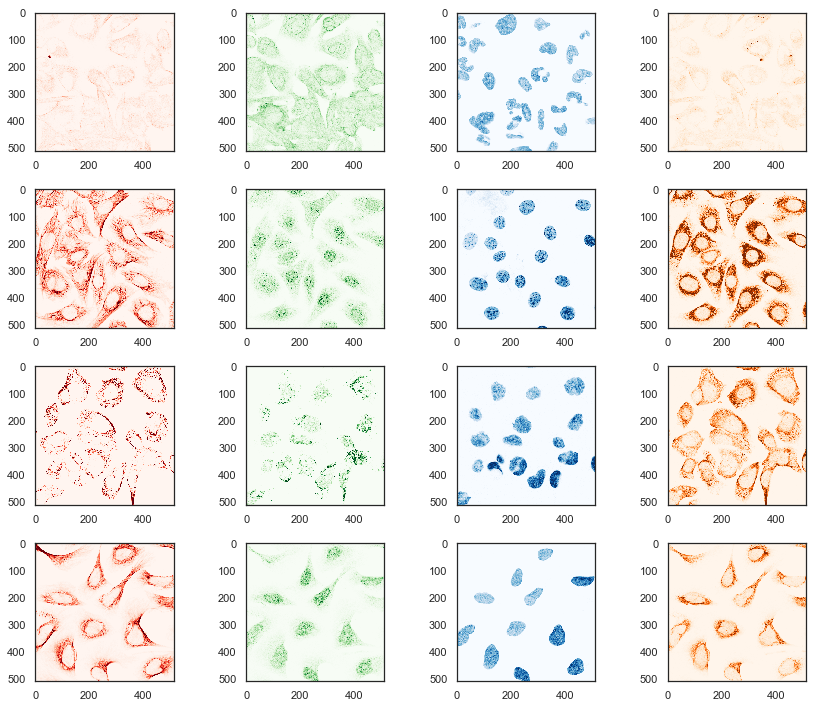

In [19]:
def plot_images_row(img_id, ax_row):
    filters = ['red', 'green', 'blue', 'yellow']
    colormaps = ['Reds', 'Greens', 'Blues', 'Oranges']
    
    for c, ax, cmap in zip(filters, ax_row, colormaps):
        filename = img_id + '_' + c + '.png'
        img=mpimg.imread(os.path.join(DIR, filename))
        imgplot = ax.imshow(img, cmap=cmap)

fig = plt.figure(figsize=(12,10))
axes = fig.subplots(nrows=4, ncols=4)

for img_id, ax_row in zip(id_list, axes):
    plot_images_row(img_id, ax_row)

plt.tight_layout()

We can see that each color is vaguely reminiscent of the others for the same image. Below is a larger version of one of the images shown in blue.

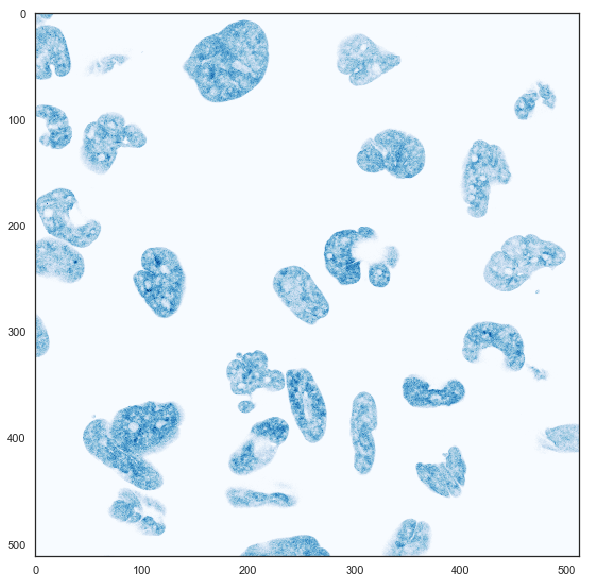

In [20]:
color = 'blue'
filename = id_list[0] + '_' + color + '.png'
img=mpimg.imread(os.path.join(DIR, filename))
plt.figure(figsize=(12,10))
plt.imshow(img, cmap="Blues")

# Baseline modeling
## Convolutional Neural Network

Conv nets take inputs as two-dimensional images and predict labels based on convolutions applied to outputs from each subsequent layer. Mathematically it is to process cross-correlations as opposed to convolutions although they are related.

For single-label classification we ask a simple question:

![car](img/streetview.jpg)

i.e. Is this a picture of a car? ∈ {yes, no}

For multi-class (per-label) classification we are interested in asking the question, "which labels are relevant to the picture?" ⊆ {car, streetlight, pedestrian, cyclist, signpost, etc..}
i.e., each instance can have multiple labels instead of a single one!

Cross-Entropy loss function is commonly used for learning a multi-class classification CNN model where overall loss on a mini-batch of n images is taken as the average additive sum of attribute-level loss with equal weight applied over all labels.

\begin{equation*}
\mathcal{L}_{ce} = -\frac{1}{n_{bs}} \sum^{n_{bs}}_{i=1}\sum^{n_{attr}}_{j=1}log\left(p(y_{i,j} = a_{i,j} | \textbf{x}_{i,j})\right)
\end{equation*}

$\textbf{x}_{i,j}$ denotes the feature vector of $\textbf{I}_{i}$ for the jth attribute label and $p(y_{i,j} = a_{i,j}|\textbf{x}_{i,j}$) is the corresponding posterior probability of $\textbf{I}_{i}$ over the ground truth $a_{i, j}$

The cross-entropy loss function is conditioning model learning to minimize training error by assuming that individual samples and classes are of equal importance. In order to achieve good performance and generalization, networks trained with CE need to have large training sets with sufficiently balanced class distributions.

## Minority Class Hard Sample Mining

We explore method of mining hard examples to supplement the baseline CE loss by selectively "borrowing majority class samples from the marginal border regions of the geometric neighborhood structure.

For hard sample mining, we first profile the minority and majority classes per label in each training mini-batch with n training samples. We profile the class distribution hj

First some supporting functions:

In [21]:
def to_one_hot(df):
    tmp = df.Target.str.get_dummies(sep=' ')
    tmp.columns = map(int, tmp.columns)
    return df.join(tmp.sort_index(axis=1))

def get_image_ids_from_dir_contents(image_dir):
    all_images = [name for name in os.listdir(image_dir) \
                  if os.path.isfile(os.path.join(image_dir, name))]
    return list(set([name.split('_')[0] for name in all_images]))

In [22]:
class TrainImageDataset(Dataset):
    """Fluorescence microscopy images of protein structures training dataset"""

    def __init__(self,
        image_dir,
        label_file,
        transform=None,
        idxs=None,
        using_pil=False
    ):
        """
        Args:
            label_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.idxs = idxs
        self.labels = to_one_hot(pd.read_csv(label_file))
        self.using_pil = using_pil
        if self.idxs is not None:
            self.labels = self.labels.iloc[self.idxs, :].\
                                                reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]
        img_red = img_name + '_red.png'
        img_blue = img_name + '_blue.png'
        img_green = img_name + '_green.png'
        img_yellow = img_name + '_yellow.png'

        if self.using_pil:
            pth2img = lambda x: io.imread(x)
        else:
            pth2img = lambda x: img_as_float(io.imread(x))

        img_red = pth2img(os.path.join(self.image_dir, img_red))
        img_blue = pth2img(os.path.join(self.image_dir, img_blue))
        img_green = pth2img(os.path.join(self.image_dir, img_green))
        img_yellow = pth2img(os.path.join(self.image_dir, img_yellow))
        labels = self.labels.iloc[idx, 2:].values
        labels = labels.astype('int')
        sample = {'image_id': img_name,
                  'image_red': img_red,
                  'image_blue': img_blue,
                  'image_green': img_green,
                  'image_yellow': img_yellow,
                  'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [23]:
class CombineColors(object):
    """Combines the the image in a sample to a given size."""
    def __init__(self, pretrained=False):
        self.pretrained = pretrained

    def __call__(self, sample):
        img_name = sample['image_id']
        img_red = sample['image_red']
        img_blue = sample['image_blue']
        img_green = sample['image_green']
        img_yellow = sample['image_yellow']
        labels = sample['labels']
        if self.pretrained:
            image = np.dstack((img_red, img_green, img_blue))
        else:
            image = np.dstack((img_red, img_blue, img_green, img_yellow))

        return {'image': image, 'labels': labels, 'image_id': img_name}


class ToPILImage(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, mode=None):
        self.mode = mode

    def __call__(self, sample):
        img_name = sample['image_id']
        image = sample['image']
        labels = sample['labels']
        image = transforms.ToPILImage(self.mode)(image)

        return {'image': image,
                'labels': labels,
                'image_id': img_name}


class RandomResizedCrop(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, size=224):
        self.size = size

    def __call__(self, sample):
        img_name = sample['image_id']
        image = sample['image']
        labels = sample['labels']
        image = transforms.RandomResizedCrop(self.size)(image)

        return {'image': image,
                'labels': labels,
                'image_id': img_name}


class RandomHorizontalFlip(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        img_name = sample['image_id']
        image = sample['image']
        labels = sample['labels']
        image = transforms.RandomHorizontalFlip()(image)

        return {'image': image,
                'labels': labels,
                'image_id': img_name}


class Resize(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, size=256):
        self.size = size

    def __call__(self, sample):
        img_name = sample['image_id']
        image = sample['image']
        labels = sample['labels']
        image = transforms.Resize(self.size)(image)

        return {'image': image,
                'labels': labels,
                'image_id': img_name}


class CenterCrop(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, size=224):
        self.size = size

    def __call__(self, sample):
        img_name = sample['image_id']
        image = sample['image']
        labels = sample['labels']
        image = transforms.CenterCrop(self.size)(image)

        return {'image': image,
                'labels': labels,
                'image_id': img_name}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        img_name = sample['image_id']
        image = sample['image']
        labels = sample['labels']
        image = transforms.ToTensor()(image)

        return {'image': image.type(torch.FloatTensor),
                'labels': torch. \
                    from_numpy(labels).type(torch.FloatTensor),
                'image_id': img_name}


class NumpyToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        img_name = sample['image_id']
        image = sample['image']
        labels = sample['labels']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))

        return {'image': torch. \
                    from_numpy(image).type(torch.FloatTensor),
                'labels': torch. \
                    from_numpy(labels).type(torch.FloatTensor),
                'image_id': img_name}


class Normalize(object):
    """Normalize a tensor image with mean and standard deviation.
    Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels,
    this transform will normalize each channel of the input ``torch.*Tensor``
    i.e.
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]``
    .. note::
        This transform acts in-place, i.e., it mutates the input tensor.
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized Tensor image.
        """
        img_name = sample['image_id']
        image = sample['image']
        labels = sample['labels']
        image = transforms.Normalize(self.mean, self.std)(image)

        return {'image': image,
                'labels': labels,
                'image_id': img_name}

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.\
                                            format(self.mean, self.std)


def get_transforms(pretrained=False):
    if pretrained:
        transform = {
            'TRAIN': transforms.Compose(
                            [CombineColors(pretrained),
                             ToPILImage(),
                             RandomResizedCrop(224),
                             RandomHorizontalFlip(),
                             ToTensor(),
                             Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
                            ]
            ),
            'DEV': transforms.Compose(
                            [CombineColors(pretrained),
                             ToPILImage(),
                             Resize(256),
                             CenterCrop(224),
                             ToTensor(),
                             Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
                            ]
            )
        }
    else:
        transform = {
            'TRAIN': transforms.Compose(
                            [CombineColors(),
                             NumpyToTensor()
                             ]
            ),
            'DEV': transforms.Compose(
                            [CombineColors(),
                             NumpyToTensor()
                             ]
            )
        }

    return transform

In [24]:
train_dataset = TrainImageDataset(image_dir=DIR,
                                     label_file="data/train.csv" if LOCAL else "input/train.csv")

In [25]:
sample = train_dataset[120]

In [26]:
sample

{'image_id': '01095156-bbb7-11e8-b2ba-ac1f6b6435d0',
 'image_red': array([[0.        , 0.        , 0.        , ..., 0.00784314, 0.03137255,
         0.02352941],
        [0.        , 0.        , 0.        , ..., 0.        , 0.02745098,
         0.05882353],
        [0.        , 0.        , 0.        , ..., 0.02745098, 0.05490196,
         0.07058824],
        ...,
        [0.        , 0.        , 0.        , ..., 0.22352941, 0.17254902,
         0.08235294],
        [0.        , 0.        , 0.        , ..., 0.09803922, 0.03529412,
         0.02352941],
        [0.        , 0.        , 0.        , ..., 0.02352941, 0.01568627,
         0.01568627]]),
 'image_blue': array([[0.02352941, 0.02352941, 0.03921569, ..., 0.23529412, 0.14117647,
         0.2627451 ],
        [0.05098039, 0.02745098, 0.03921569, ..., 0.15294118, 0.2       ,
         0.14509804],
        [0.01568627, 0.03921569, 0.03529412, ..., 0.19215686, 0.16862745,
         0.17647059],
        ...,
        [0.        , 0.     

In [27]:
sample['image_red'].shape == sample['image_blue'].shape == \
sample['image_green'].shape ==  sample['image_yellow'].shape

True

In [28]:
len(sample['labels']) == 28

True

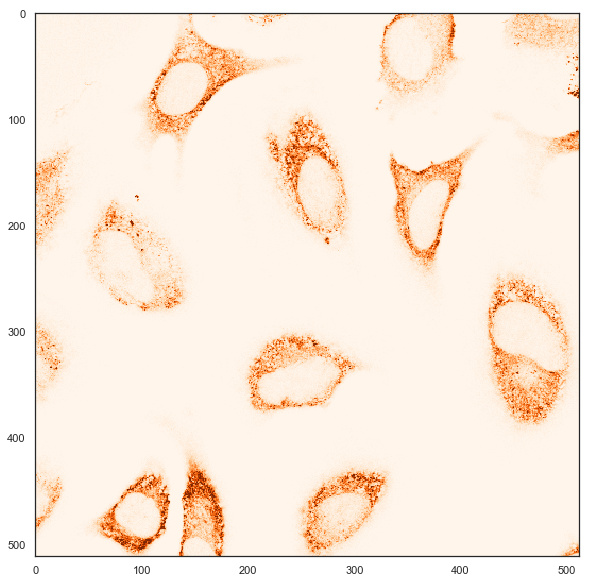

In [29]:
plt.figure(figsize=(12,10))
plt.imshow(sample['image_yellow'], cmap="Oranges")

In [30]:
transform = get_transforms(pretrained=False)
train_dataset = TrainImageDataset(image_dir=DIR,
                                     label_file="data/train.csv" if LOCAL else "input/train.csv",
                                     transform=transform['TRAIN'])
kwargs = {'batch_size': 32}
trainLoader = DataLoader(train_dataset, shuffle=True, **kwargs)

In [31]:
data = next(iter(trainLoader))
inputs, labels = data['image'], data['labels']

In [32]:
nbs = kwargs['batch_size'] # num examples in batch
ncl = 28 # num classes

#### Class Distribution profile

$h_k^j$ denotes the number of training samples with j-th attribute value assigned to class k

In [33]:
hjk = labels.sum(0); hjk

tensor([12.,  1.,  4.,  2.,  2.,  1.,  2.,  3.,  0.,  1.,  1.,  0.,  2.,  0.,
         2.,  0.,  0.,  0.,  1.,  1.,  1.,  3.,  2.,  2.,  2., 11.,  0.,  0.])

In [34]:
cls_labels = torch.arange(ncl); cls_labels # not required 

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [35]:
sorted_cls_labels = np.argsort(hjk); sorted_cls_labels

tensor([13, 17, 16, 15, 26, 11,  8, 27,  1,  9, 10,  5, 20, 19, 18, 24, 23, 22,
         6,  3, 14,  4, 12, 21,  7,  2, 25,  0])

In [36]:
sorted_hjk = hjk[sorted_cls_labels]; sorted_hjk

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  4., 11., 12.])

To determine minority class indexes, for the multiclass setting, we set ρ=50%, meaning that all minority classes collectively account for at most half or less samples per batch. The function below is later vectorized in pytorch

In [37]:
th = .5 * nbs

def get_min_class_boundary(arr):
    for idx in torch.arange(len(arr)):
        if arr[:idx].sum() > th:
            return idx - 1
    return arr.size

In [38]:
bound = get_min_class_boundary(sorted_hjk); bound

tensor(19)

In [39]:
sorted_hjk[:bound].sum() # should be less than or equal  16

tensor(15.)

In [40]:
sorted_hjk = sorted_hjk[:bound]
min_cls_labels = sorted_cls_labels[:bound]

In [41]:
idxs = np.argsort(min_cls_labels) # unsort
min_cls_labels = min_cls_labels[idxs] 
hjk = sorted_hjk[idxs]
print(min_cls_labels)
print(hjk)

tensor([ 1,  5,  6,  8,  9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26,
        27])
tensor([1., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 2., 2., 2., 0.,
        0.])


Unfortunately the minority classes which have less than two samples must be ignored so we must also filter on hjk > 1. This enables us to use a more flexible loss function, e.g. triplet loss which requires at least two matched samples as it is impossible to construct a triple where only one or no sample images exist for that class in the batch.

In [42]:
msk = hjk > 1
hjk = hjk[msk]
min_cls_labels = min_cls_labels[msk]
print(min_cls_labels)
print(hjk)

tensor([ 6, 22, 23, 24])
tensor([2., 2., 2., 2.])


Below I use a function from source that does the above in pytorch.

In [43]:
def get_minority_classes(y, batchSz):
    sorted_hjk, ix = y.sum(0).sort()
    mask = torch.cumsum(sorted_hjk, 0) <= .5 * batchSz
    sorted_hjk = sorted_hjk[mask]
    sorted_, sorted_ix = ix = ix[mask].sort()
    
    return sorted_[sorted_hjk[sorted_ix] > 1]

min_cls_labels = get_minority_classes(labels, nbs); min_cls_labels

tensor([ 3,  4, 23, 24])

Note: possible difference in class indices. Since sort is somewhat random in its ordering of integer values that are the same, class choice may be somewhat random at margin of minority classes and non-minority classes.

Given the minortiy classes, let us find the hardness metric for sampling instances which encourage model learning to concentrate on weak recognitions or obvious mistakes. Explicitly, at the class level, we quantify sample hardness regarding a given class per label by saying for each minority class c of the attribute label j, we refer to "hard-positives" as follows: 

\begin{align}
P_{c,j}^{cls} = \{x_{i,j} | a_{i,j} = c\text{, low } p(y_{i,j} = c | x_{i,j})\}
\end{align}

\begin{align}
N_{c,j}^{cls} = \{x_{i,j} | a_{i,j} \neq c\text{, low } p(y_{i,j} = c | x_{i,j})\}
\end{align}

Create some random predictions in the range [0-1]:

In [44]:
bs = (nbs, ncl) # batch array size
preds = np.random.rand(*bs) # random predictions for batch 
preds = torch.Tensor(preds)

Identify positive examples which are associated with a minority class.

$x_{i,j} | a_{i,j} = c$

In [45]:
y_min = labels[:, min_cls_labels]
# y_min = labels.numpy()[:, min_cls_labels.numpy()]
msk = y_min == 1

In [46]:
P = torch.nonzero(msk); P # anchor instances
# P = np.argwhere(msk)

tensor([[ 0,  1],
        [ 1,  3],
        [ 5,  3],
        [16,  0],
        [17,  1],
        [22,  2],
        [27,  2],
        [30,  0]])

Identify negative examples which are associated with a minority class.

$x_{i,j} | a_{i,j} \neq c$

In [47]:
N = torch.nonzero(~msk)
# N = np.argwhere(~msk)

get probabilities for positive examples associated with a minority class

In [48]:
preds_min = preds[:, min_cls_labels]
preds_P = preds_min[msk]

get probabilities for negtive examples associated with a minority class

In [49]:
preds_N = preds_min[~msk]

select top 3 (if needed)

In [50]:
k = 3
preds_P[np.argsort(preds_P)][:k]

tensor([0.0967, 0.1166, 0.1339])

In [51]:
preds_N[np.argsort(preds_N)][-k:]

tensor([0.9383, 0.9697, 0.9961])

### Incremental Batch-Wise Minority Class Example Mining

Now that we know how to break down the batch into minority classes sorted on predicted probabilities, we can think about how to select hard examples. Specifically, at training time, for a minority class c of attribute label j (or a minority class instance $x_{i,j}$ ) in each training batch data, we select κ hard-positives as the bottom-κ scored on c (or bottom-κ (largest) distances to $x_{i,j}$ ), and κ hard-negatives as the top-κ scored on c (or top-κ (smallest) distance to $x_{i,j}$ ), given the current model (or feature space)

OK, lets put it all together. Given a tensor of y_predictions for minority labels...

In [52]:
preds_min[:5] # head

tensor([[0.0633, 0.2212, 0.5761, 0.0399],
        [0.2465, 0.2886, 0.5582, 0.5060],
        [0.3730, 0.0822, 0.4172, 0.1617],
        [0.7269, 0.8818, 0.6114, 0.2065],
        [0.3922, 0.7251, 0.9282, 0.0108]])

We form at most $κ^2$ triplets $T = \{(x_{a,j}, x_{+,j}, x_{-,j})_s\}_{s=1}^{\kappa^2}$ with respect to $x_{a, j}$, and a total of at most $\left|X_{min}\right| × κ^2$ triplets $T$ for all anchors $X_{min}$ across all the minority classes of every attribute label. The meshgrid function is used to create row-wise combinations of indexes/probabilities.

In [53]:
k = 3
for idx, row in enumerate(P):
    anchor_idx, anchor_class = row
    mask = (P[:, 1] == anchor_class)
    mask[idx] = 0
    pos_idxs = P[mask]
    pos_preds, sorted_= preds_min[pos_idxs[:, 0], pos_idxs[:, 1]].sort()
    pos_idxs = pos_idxs[sorted_][:k]
    pos_preds = pos_preds[:k]

    mask = (N[:, 1] == anchor_class)
    neg_idxs = N[mask]
    neg_preds, sorted_= preds_min[neg_idxs[:, 0], neg_idxs[:, 1]].sort()
    neg_idxs = neg_idxs[sorted_][-k:]
    neg_preds = neg_preds[:k]
    
    a = [idx]
    n_p = pos_idxs.shape[0]
    n_n = neg_idxs.shape[0]
    grid = torch.stack(torch.meshgrid([torch.Tensor(a).long(), torch.arange(n_p), torch.arange(n_n)])).reshape(3, -1).t()
    print(torch.cat([P[grid[:, 0]], pos_idxs[grid[:, 1]], neg_idxs[grid[:, 2]]], 1))
    print("")
    print(torch.stack([preds_P[grid[:, 0]], pos_preds[grid[:, 1]], neg_preds[grid[:, 2]]], 1))
    print("")


tensor([[ 0,  1, 17,  1, 21,  1],
        [ 0,  1, 17,  1, 13,  1],
        [ 0,  1, 17,  1,  3,  1]])

tensor([[0.2212, 0.1166, 0.0076],
        [0.2212, 0.1166, 0.0094],
        [0.2212, 0.1166, 0.0822]])

tensor([[ 1,  3,  5,  3, 31,  3],
        [ 1,  3,  5,  3, 19,  3],
        [ 1,  3,  5,  3, 13,  3]])

tensor([[0.5060, 0.1403, 0.0108],
        [0.5060, 0.1403, 0.0399],
        [0.5060, 0.1403, 0.0643]])

tensor([[ 5,  3,  1,  3, 31,  3],
        [ 5,  3,  1,  3, 19,  3],
        [ 5,  3,  1,  3, 13,  3]])

tensor([[0.1403, 0.5060, 0.0108],
        [0.1403, 0.5060, 0.0399],
        [0.1403, 0.5060, 0.0643]])

tensor([[16,  0, 30,  0, 25,  0],
        [16,  0, 30,  0,  9,  0],
        [16,  0, 30,  0, 20,  0]])

tensor([[0.1339, 0.4754, 0.0146],
        [0.1339, 0.4754, 0.0633],
        [0.1339, 0.4754, 0.0678]])

tensor([[17,  1,  0,  1, 21,  1],
        [17,  1,  0,  1, 13,  1],
        [17,  1,  0,  1,  3,  1]])

tensor([[0.1166, 0.2212, 0.0076],
        [0.1166, 0.2212, 0.009

I had first implemented this in numpy as shown in the commentedc code below for those interested.

In [54]:
# def mine_positives(anchor, labels, predictions):
#     cls = np.argwhere(labels[anchor] == 1)
#     P = np.argwhere(labels == 1)
#     preds_P = predictions[labels == 1]
#     out = P[np.isin(P[:, 1], cls)]
#     out_preds = preds_P[np.isin(P[:, 1], cls)]
#     input_mask = out[:, 0] != anchor
#     out = out[input_mask]
#     out_preds = out_preds[input_mask]
#     sorted_ = out_preds.argsort()
#     return out[sorted_], out_preds[sorted_]

# def mine_negatives(anchor, labels, predictions):
#     cls = np.argwhere(labels[anchor] == 0)
#     N = np.argwhere(labels == 0)
#     preds_N = predictions[labels == 0]
#     out = N[np.isin(N[:, 1], cls)]
#     out_preds = preds_N[np.isin(N[:, 1], cls)]
#     sorted_ = out_preds.argsort()
#     return out[sorted_], out_preds[sorted_]


# anchor_idxs = P[:, 0]
# k = 3
# for idx in anchor_idxs:
#     anc_examples, anc_preds = P[P[:, 0] == idx], preds_P[P[:, 0] == idx]
#     pos_examples, pos_preds = mine_positives(idx, y_min, preds_min)
#     neg_examples, neg_preds = mine_negatives(idx, y_min, preds_min)
#     pos_examples = pos_examples[:k]
#     neg_examples = neg_examples[-k:]
#     n_a = anc_examples.shape[0]
#     n_p = pos_examples.shape[0]
#     n_n = neg_examples.shape[0]
#     grid = np.array(np.meshgrid(np.arange(n_a), np.arange(n_p), np.arange(n_n))).T.reshape(-1,3)
#     print(anc_examples[grid[:, 0]], pos_examples[grid[:, 1]], neg_examples[grid[:, 2]])
#     print("")

We define $\Omega$ as the minimum percentage count of data samples required over all classes in order to form an overall uniform (i.e. balanced) class distribution in the training data . eta is a hyperparameter to be tuned by cross validation.

In [55]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample

    source: https://github.com/adambielski/siamese-triplet/blob/master/losses.py
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = F.l1_loss(anchor, positive, reduction='sum')
        distance_negative = F.l1_loss(anchor, negative, reduction='sum')
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()


class IncrementalClassRectificationLoss(nn.Module):

    def __init__(self,
        margin,
        alpha,
        batchSz,
        k,
        class_level_hard_mining=True,
        sigmoid=True
    ):
        super(IncrementalClassRectificationLoss, self).__init__()

        self.margin = margin
        self.alpha = alpha
        self.batchSz = batchSz
        self.k = k
        self.class_level_hard_mining = class_level_hard_mining
        self.sigmoid = sigmoid
        self.trip_loss = TripletLoss(margin)
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, input, target, X):
        bce = self.bce(input, target)
        idxs = get_minority_classes(target, batchSz=self.batchSz)
        if self.sigmoid:
            input = torch.sigmoid(input)
            y_min = target[:, idxs]
            preds_min = input[:, idxs]
        else:
            y_min = target[:, idxs]
            preds_min = input[:, idxs]

        y_mask = y_min == 1
        P = torch.nonzero(y_mask)
        N = torch.nonzero(~y_mask)
        preds_P = preds_min[y_mask]

        k = self.k
        idx_tensors = []
        pred_tensors = []
        # would like to vectorize this
        for idx, row in enumerate(P):
            anchor_idx, anchor_class = row
            mask = (P[:, 1] == anchor_class)
            mask[idx] = 0
            pos_idxs = P[mask]
            pos_preds, sorted_= preds_min[pos_idxs[:, 0], pos_idxs[:, 1]].sort()
            pos_idxs = pos_idxs[sorted_][:k]
            pos_preds = pos_preds[:k]

            mask = (N[:, 1] == anchor_class)
            neg_idxs = N[mask]
            neg_preds, sorted_= preds_min[neg_idxs[:, 0], neg_idxs[:, 1]].sort()
            neg_idxs = neg_idxs[sorted_][-k:]
            neg_preds = neg_preds[:k]

            a = [idx] # anchor index in P
            n_p = pos_idxs.shape[0]
            n_n = neg_idxs.shape[0]
            # create 2d array with indices for anchor, pos and neg examples
            grid = torch.stack(torch.meshgrid([torch.Tensor(a).long(), torch.arange(n_p), torch.arange(n_n)])).reshape(3, -1).t()
            idx_tensors.append(torch.cat([P[grid[:, 0]], pos_idxs[grid[:, 1]], neg_idxs[grid[:, 2]]], 1))
            pred_tensors.append(torch.stack([preds_P[grid[:, 0]], pos_preds[grid[:, 1]], neg_preds[grid[:, 2]]], 1))

        try:
            if self.class_level_hard_mining:
                idx_tensors = torch.cat(idx_tensors, 0)
                pred_tensors = torch.cat(pred_tensors, 0)
            else:
                # TODO: implement instance level hard mining
                pass
            crl = self.trip_loss(pred_tensors[:, 0], pred_tensors[:, 1], pred_tensors[:, 2])
            loss = self.alpha * crl + (1 - self.alpha) * bce

            return loss

        except RuntimeError:
            # TODO: figure out why we are sometimes getting RuntimeError in test
            logging.warning('RuntimeError in loss statement')

            return bce

In [56]:
omega = counts.min() / counts.max() # class imbalance measure as 
eta = 0.01
alpha = omega * eta
print(alpha)
# don't use sigmoid layer since preds are already in 0-1 range
criterion = IncrementalClassRectificationLoss(0.5, alpha, 28, 3, sigmoid=False)

8.537058595265812e-06


And finally, the loss calculated on the mini-batch used as an example is...

In [57]:
criterion(preds, labels, inputs)

tensor(0.9530, dtype=torch.float64)

### Build Datasets/Loaders

In [325]:
class ArgContainer():
    def __init__(self, 
                 network_name,
                 crit,
                 batchSz, 
                 train_images_path,
                 train_csv_path, 
                 nSubsample, 
                 pretrained
    ):
        self.network_name = network_name
        self.crit = crit
        self.batchSz = batchSz
        self.train_images_path = train_images_path
        self.train_csv_path = train_csv_path
        self.nSubsample = nSubsample
        self.pretrained = pretrained


args = ArgContainer("resnet34", "crl", 32, DIR, "data/train.csv" if LOCAL else "input/train.csv", 0, True)

kwargs = {'batch_size': args.batchSz}

In [326]:
def get_dataset(args, idxs=None, train=True):
    if args.pretrained:
        using_pil = True
    else:
        using_pil = False

    transform = get_transforms(args.pretrained)
    if train:
        image_dir = args.train_images_path
        label_file = args.train_csv_path
        if label_file is None:
            raise ValueError('no label_file provided for training')
        if idxs is None:
            raise ValueError('must specify idxs for training')
        dataset = TrainImageDataset(
                         image_dir=image_dir,
                         label_file=label_file,
                         transform=transform['TRAIN'],
                         idxs=idxs,
                         using_pil=using_pil)
    else:
        image_dir = args.test_images_path
        dataset = TestImageDataset(
                         image_dir=image_dir,
                         transform=transform['DEV'],
                         using_pil=using_pil)

    return dataset

def get_train_test_split(args, val_split=0.10, distributed=False, **kwargs):
    n_subsample = args.nSubsample

    with open(args.train_csv_path, 'r') as f:
        n_images = sum(1 for row in f.readlines()) - 1 # -1 for header row
    if n_subsample != 0:
        arr = np.random.choice(n_images, n_subsample, replace=False)
        train_idxs = arr[:int(n_subsample * (1 - val_split))]
        dev_idxs = arr[int(n_subsample * (1 - val_split)):]
    else:
        arr = np.random.choice(n_images, n_images, replace=False)
        train_idxs = arr[:int(n_images * (1 - val_split))]
        dev_idxs = arr[int(n_images * (1 - val_split)):]

    trainset = get_dataset(args, idxs=train_idxs)
    devset = get_dataset(args, idxs=dev_idxs)

    if distributed:
        trainLoader, devLoader, args.batchSz = partition_dataset(trainset, devset, args.batchSz)
    else:
        trainLoader = DataLoader(trainset, shuffle=True, **kwargs)
        devLoader = DataLoader(devset, shuffle=False, **kwargs)

    return trainLoader, devLoader

def get_loss_function(lf='bce', args=None):
    if lf == 'bce':
        return BCEWithLogitsLoss()

    elif lf == 'f1':
        return f1_loss

    elif lf == 'crl':
        if args:
            return IncrementalClassRectificationLoss(*args)
        raise ValueError('args for CRL not found')
    else:
        raise ModuleNotFoundError('loss function not found')

In [327]:
trainLoader, devLoader = get_train_test_split(args, **kwargs)

In [369]:
def freeze_pretrained_model_weights(net):
    for param in net.features.parameters():
        param.require_grad = False

    return net

def freeze_pretrained_model_weights_renet(net):
    for param in net.parameters():
        param.requires_grad = False

def swap_last_layer(net):
    num_features = net.classifier[-1].in_features
    features = list(net.classifier.children())[:-1] # Remove last layer
    features.extend([Linear(num_features, 28)]) # Add our layer with 28 outputs. activation in loss function
    net.classifier = Sequential(*features) # Replace the model classifier

    return net

def swap_last_layer_resnet(net):
    num_features = net.fc.in_features
    net.fc = nn.Linear(num_features, 28)

    return net

def get_network(args):
    name = args.network_name
    pretrained = args.pretrained
    if hasattr(models, name):
        torchvision_model = getattr(models, name)
        net = torchvision_model()
        if pretrained:
        # Freeze training for all layers
        # Newly created modules have require_grad=True by default
            if 'resnet' in name:
                freeze_pretrained_model_weights_renet(net)
            else:
                freeze_pretrained_model_weights(net)

        if 'resnet' in name:
            net = swap_last_layer_resnet(net)
        else:
            net = swap_last_layer(net)

    else:
        net = Net()

    return net

In [371]:
net = get_network(args)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [62]:
net = torch.nn.DataParallel(net) if LOCAL else torch.nn.DataParallel(net).cuda()

In [63]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [64]:
lf_args = [0.5, 8.537058595265812e-06, args.batchSz, 5, True, True]
criterion = get_loss_function('crl', lf_args)

In [65]:
def plot_lr(optimizer, net, trainLoader, criterion, start_lr=-7, end_lr=-1, num_iter=100):
    xs = np.logspace(start_lr, end_lr, num_iter)
    ys = []
    for i, data in enumerate(trainLoader, 0):
        if i == 100:
            break
        for param_group in optimizer.param_groups:
            param_group['lr'] = xs[i]
        net.train()
        # get the inputs
        inputs, labels = data['image'].cuda(), data['labels'].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss_inputs = (outputs, labels, inputs)
        loss = criterion(*loss_inputs)
        loss.backward()
        optimizer.step()
        ys.append(loss.item())
    plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    plt.plot(xs, ys, 'b-')
    plt.xscale('log')
    plt.title('Learning rate curve')
    plt.ylabel('loss')
    plt.xlabel('learning rate')

if not LOCAL and GPU:
    plot_lr(optimizer, net, trainLoader, criterion)

In [90]:
def f1_loss(preds, labels, th, epsilon=1E-8):
    
    tp = (preds + labels.data.byte()).eq(2).sum().float()
    fp = (preds - labels.data.byte()).eq(1).sum().float()
    fn = (preds - labels.data.byte()).eq(255).sum().float()
    tn = (preds + labels.data.byte()).eq(0).sum().float()
    p = tp / (tp + fp + epsilon)
    r = tp / (tp + fn + epsilon)
    f1 = 2 * p * r / (p + r + epsilon)
    return 1 - f1.mean()

## RESULTS

### VGG16 Pretrained, 25 epoch, cosine annealing Min LR-1e-4, Max LR-1e-3, unfreeze at epoch 18

In [ ]:
import scipy.optimize as opt

In [66]:
trainLoader, devLoader = get_train_test_split(args, **kwargs)

In [67]:
results1_dir = 'work/vgg16/hpa/vgg16-3ch-cyclic_lr-25epoch'
if GPU:
    net.module.load_state_dict(torch.load(os.path.join(results1_dir, '25.pth')))
else:
    net.module.load_state_dict(torch.load(os.path.join(results1_dir, '25.pth'), map_location='cpu'))

In [311]:
# data = next(iter(trainLoader))
# inputs, labels = data['image'], data['labels']
# outputs = net(inputs)

In [312]:
def f1_soft(outputs, labels, th, epsilon=1E-8):
    preds = outputs.sigmoid().gt(torch.Tensor(th))
    tp = (preds + labels.data.byte()).eq(2).sum().float()
    fp = (preds - labels.data.byte()).eq(1).sum().float()
    fn = (preds - labels.data.byte()).eq(255).sum().float()
    tn = (preds + labels.data.byte()).eq(0).sum().float()
    p = tp / (tp + fp + epsilon)
    r = tp / (tp + fn + epsilon)
    f1 = 2 * p * r / (p + r + epsilon)
    return (1 - f1.mean()).item()

def fit_val(x,y):
    th = np.array([.5])
    f1 = F1Soft()
    wd = 1e-5
    error = lambda p: np.concatenate((f1_soft(x, y, p), wd*p), axis=None)
    p, success = opt.leastsq(error, th)
    return p

In [324]:
# th = np.zeros((28,))
# for ix in range(28):
#     y_true = labels[:, ix]
#     y_pred = outputs[:, ix].detach()
#     th[ix] = fit_val(y_pred, y_true)

array([ 4.50000000e-01, -1.26674482e-09,  4.50000000e-01, -1.26674482e-09,
       -1.26674482e-09,  4.50000000e-01, -1.26674482e-09, -1.26674482e-09,
       -1.26674482e-09, -1.26674482e-09, -1.26674482e-09, -1.26674482e-09,
       -1.26674482e-09,  3.64144032e-01,  1.93713915e-02, -1.26674482e-09,
       -1.26674482e-09, -1.26674482e-09, -1.26674482e-09, -1.26674482e-09,
       -1.26674482e-09,  1.49600001e-01, -1.26674482e-09,  4.50000000e-01,
       -1.26674482e-09,  4.50000000e-01, -1.26674482e-09, -1.26674482e-09])

In [ ]:
training_th = []
testing_th = []
for i, data in enumerate(devLoader, 0):
    net.eval()
    # get the inputs
    if GPU:
        inputs, labels = data['image'].cuda(), data['labels'].cuda()
    else:
        inputs, labels = data['image'], data['labels']

    outputs = net(inputs)
    
    th = np.zeros((28,))
    for ix in range(28):
        if GPU:
            y_true = labels[:, ix].cpu()
            y_pred = outputs[:, ix].detach().cpu()
        else:
            y_true = labels[:, ix]
            y_pred = outputs[:, ix].detach()
        th[ix] = fit_val(y_pred, y_true)
    training_th.append(th)

In [ ]:
# for epoch in range(3):  # loop over the dataset multiple times
#     training_loss = 0.0
#     testing_loss = 0.0
#     for i, data in enumerate(trainLoader, 0):
#         net.train()
#         # get the inputs
#         inputs, labels = data['image'].cuda(), data['labels'].cuda()

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss_inputs = (outputs, labels, inputs)
#         loss = criterion(*loss_inputs)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         training_loss += loss.item()
#         if i % 50 == 49:    # print every 50 mini-batches
#             print('[%d, %5d] training loss: %.3f' %
#                   (epoch + 1, i + 1, training_loss / 50))
#             training_loss = 0.0
#     for i, data in enumerate(devLoader, 0):
#         net.eval()
#         # get the inputs
#         inputs, labels = data['image'].cuda(), data['labels'].cuda()
        
#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss_inputs = (outputs, labels, inputs)
#         loss = criterion(*loss_inputs)

#         # print statistics
#         testing_loss += loss.item()
#         if i % 50 == 49:    # print every 50 mini-batches
#             print('[%d, %5d] testing loss: %.3f' %
#                   (epoch + 1, i + 1, testing_loss / 50))
#             testing_loss = 0.0

# print('Finished Training')

In [322]:
# cols = ['partial_epoch', 'loss', 'acc', 'prec', 'rec']
# train1_df = pd.read_csv(os.path.join(results1_dir, 'train.csv'), names=cols, encoding='utf-8', header=None)
# test1_df = pd.read_csv(os.path.join(results1_dir, 'test.csv'), names=cols, encoding='utf-8', header=None)

Text(0.5, 1.0, 'epoch vs recall')

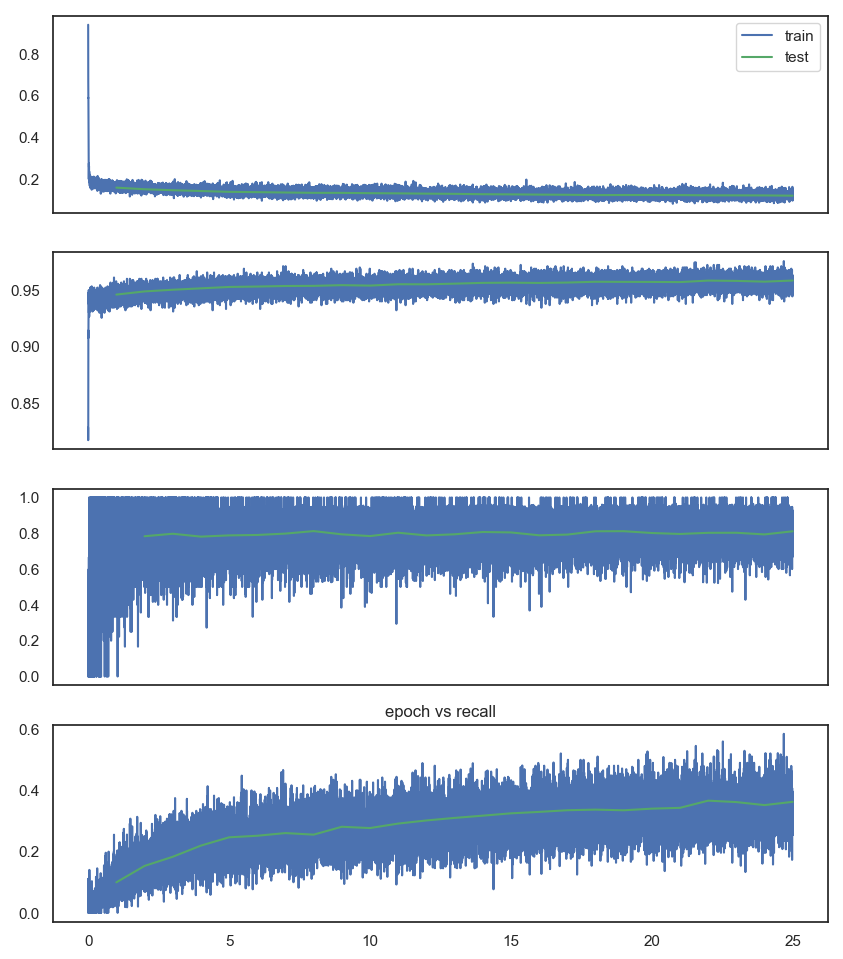

In [323]:
# fig, ax = plt.subplots(4, figsize=(10, 12), dpi=100, sharex=True)
# fig.set_facecolor('white')
# ax[0].plot(train1_df.partial_epoch, train1_df.loss, 'b-', label='train')
# ax[0].plot(test1_df.partial_epoch, test1_df.loss, 'g-', label='test')
# ax[1].plot(train1_df.partial_epoch, train1_df.acc, 'b-', label='train')
# ax[1].plot(test1_df.partial_epoch, test1_df.acc, 'g-', label='test')
# ax[2].plot(train1_df.partial_epoch, train1_df.prec, 'b-', label='train')
# ax[2].plot(test1_df.partial_epoch, test1_df.prec, 'g-', label='test')
# ax[3].plot(train1_df.partial_epoch, train1_df.rec, 'b-', label='train')
# ax[3].plot(test1_df.partial_epoch, test1_df.rec, 'g-', label='test')
# ax[0].legend(loc='upper right')
# plt.title('epoch vs recall')
# # plt.ylabel('recall')
# # plt.xlabel('epoch')

## Compute Test Predictions

In [ ]:
# TODO: implement get test preds